In [1]:
import glob
import cv2
import pandas as pd
from skimage import io
from skimage import transform as trf
from scipy import ndimage
from PIL import Image
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import imutils
import json

In [2]:
def plot_image(images, captions=None, cmap='gray' ):
    f, axes = plt.subplots(1, len(images), sharey=True,figsize=(75,50))
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In [3]:
#Read CSV file of annotation mask
df_csv=pd.read_csv('./data/via_export_csv.csv')
df_csv.head()
    
#df_csv.region_shape_attributes[0]


,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,0001.jpg,2912,{},1,0,"{""name"":""polygon"",""all_points_x"":[16,19,26,29,...","{""particle"":""""}"
1,0002.jpg,3546,{},1,0,"{""name"":""polygon"",""all_points_x"":[10,13,15,17,...","{""particle"":""""}"
2,0003.jpg,5202,{},1,0,"{""name"":""polygon"",""all_points_x"":[25,29,30,33,...","{""particle"":""""}"
3,0004.jpg,3382,{},1,0,"{""name"":""polygon"",""all_points_x"":[12,15,19,23,...","{""particle"":""""}"
4,0005.jpg,4289,{},1,0,"{""name"":""polygon"",""all_points_x"":[2,5,7,9,10,1...","{""particle"":""""}"


In [4]:
idx=df_csv[df_csv.filename=='0003.jpg'].index.item()
idx
my_attr=json.loads(df_csv.region_shape_attributes[idx])
type(my_attr)

dict

In [5]:
def getXYAttributes(image_fileName):
    #getIndexrowinDataframe
    idx=df_csv[df_csv.filename==image_fileName].index.item()
    region_shape_dictionary=json.loads(df_csv.region_shape_attributes[idx])
    XY_List=[]
    for x,y in zip(region_shape_dictionary.get('all_points_x'),region_shape_dictionary.get('all_points_y')):
        XY_List.append([x,y])
    return XY_List

In [6]:
data_set_image_path='./data'
image_paths=glob.glob(os.path.join(data_set_image_path,"","*.JPG"))
image_paths[:3]

['./data\\0001.jpg', './data\\0002.jpg', './data\\0003.jpg']

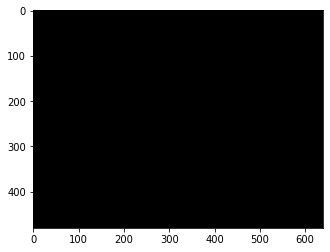

In [7]:
image_black=np.zeros((480,640,3),dtype=np.int32)
image_black=image_black#+80
#plt.imshow(image_raw)
cv2.imwrite('blind_image.jpg',image_black)


image_raw=cv2.imread('blind_image.jpg')
plt.imshow(image_raw)



In [8]:
file_idx=10
file_name=os.path.basename(image_paths[file_idx])
print('filename is :{0}'.format(file_name))

filename is :0011.jpg


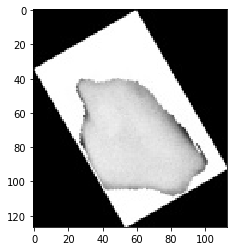

In [9]:
img_particle=cv2.imread(image_paths[file_idx])
plt.imshow(img_particle)


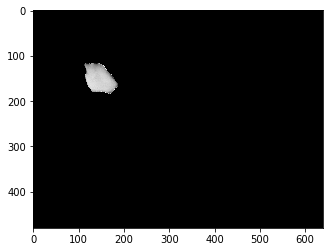

In [10]:
XY_property=getXYAttributes(file_name)

src_mask=np.zeros(img_particle.shape,img_particle.dtype)

poly=np.array([XY_property])
cv2.fillPoly(src_mask, [poly], (255, 255, 255))

src=img_particle
dst=image_raw
center=(150,150)
output = cv2.seamlessClone(src, dst, src_mask, center,0, cv2.NORMAL_CLONE) # Very Important code line
plt.imshow(output)



In [11]:
#poly

In [12]:
#help(cv2.seamlessClone)
#This section will create methods to generate the synthetic images and annotation
np.random.seed(213)

In [13]:
#This is the Method to Randomly select n particle images and return corresponding image list along with its property
#Input1 = number of images (num_images)
#input2= list of image file name
#input3= duplicate allowed (duplicate particle is allowed or not)
#output1=List of images
#output2=list of tuples of x,y coordinates

def getImageDetails(num_images,list_image_filename,background_image_shape,replace=False):
    #Create list of random images
    
    image_files=np.random.choice(list_image_filename,num_images,replace=replace)
    
    #create the image list
    image_list=[]
    for count in range(0,num_images,1):
        img=cv2.imread(os.path.join('./data','',image_files[count]))
        XY_property=getXYAttributes(image_files[count])
        #poly=np.array([XY_property])
        center_paste=getPasteLocation(img,background_image_shape)
        #image_list.append([img,poly,center_paste])
        image_list.append([img,XY_property,center_paste])
        
    return image_list
    

In [14]:
#Getting the Probable locations(points) in synthetic image where particle can be pasted
# Particle have to have suffiecient distance margin from boundaries else seamlessclone() method fails

def getPasteLocation(particle_img,background_image_shape):
    
    background_width,background_height=background_image_shape[1],background_image_shape[0]
    return_list=[] # Append with [image,XY center] , center should be filled with tuples(X,Y)
    
    particle_width,particle_height=particle_img.shape[1],particle_img.shape[0]
    #Range for width with allowance of 1 pixel
    width_min=int(particle_width/2)+1
    width_max=background_width-int(particle_width/2)-1
        
    #Range for height with allowance of 1 pixel
    height_min=int(particle_height/2)+1 
    height_max=background_height-int(particle_height/2)-1
            
    choice_X=random.randrange(width_min,width_max)
    choice_Y=random.randrange(height_min,height_max)
            
    return (choice_X,choice_Y)               
        

In [15]:
#Drawing boxes around the particle
def getBoundingBox(poly_list,relative_center):
    x_list=[]
    y_list=[]
    
    for points in poly_list:
        x_list.append(points[0])
        y_list.append(points[1])
    x_min=min(x_list)
    y_min=min(y_list)
    
    x_max=max(x_list)
    y_max=max(y_list)
    
    width=x_max-x_min
    height=y_max-y_min
    
    #Calculating coordinates relative to background image frame
    X_PARTICLE_CENTER=relative_center[0]
    Y_PARTICLE_CENTER=relative_center[1]
    
    X_MIN_RELATIVE=relative_center[0]-int(width/2)
    X_MAX_RELATIVE=relative_center[0]+int(width/2)
    
    Y_MIN_RELATIVE=relative_center[1]-int(height/2)
    Y_MAX_RELATIVE=relative_center[1]+int(height/2)
    
    return[(X_MIN_RELATIVE,Y_MIN_RELATIVE),(X_MAX_RELATIVE,Y_MAX_RELATIVE)]

In [16]:
def writeAnnotation(path,filename,bounding_coordinate_list,class_name='particle'):
    
    write_list=[]
    for bbox in bounding_coordinate_list:
        x_min=bbox[0][0]
        y_min=bbox[0][1]
        
        x_max=bbox[1][0]
        y_max=bbox[1][1]
        
        write_list.append([filename,x_min,y_min,x_max,y_max,class_name])
        
    
    df_to_write=pd.DataFrame(write_list)
    path_to_save=os.path.join(path,'',str.split(filename,'.')[0]+'.csv')
    df_to_write.to_csv(path_to_save,header=None,index=None,sep=',')
        
    

In [17]:
sample_list=[]
sample_list.append(['abhishek','megha'])
sample_list.append(['Polly','Randhir'])
df=pd.DataFrame(sample_list)
df

,0,1
0,abhishek,megha
1,Polly,Randhir


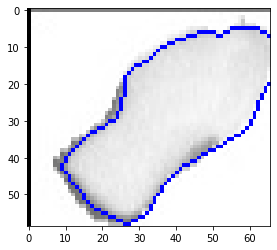

In [18]:
#Sample to test if getImageDetails() method is working as expected
# It is taking image and its polygon points in return 
#These polygon point is required to create mask when we paste the particle in Synthetic image
#If we keep refreshing this cell we will get new images
flls=list(df_csv.filename)
img_fl=getImageDetails(10,flls,image_raw.shape,True)
img_test=img_fl[0][0]
XY_polly=np.array([img_fl[0][1]])
#XY_polly
img_test=cv2.polylines(img_test,[XY_polly],True,(0,0,255))
plt.imshow(img_test)

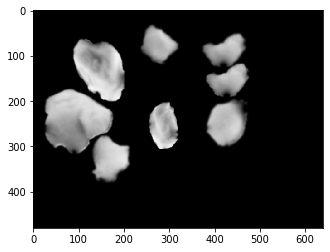

In [19]:
#Testing the above codes by generating 1 image with 30 particles in it
particle_file_name=list(df_csv.filename)
particle_details=getImageDetails(8,particle_file_name,image_raw.shape,replace=True)
#len(particle_details)
#Creating list of images
#particle_images=[]

#Initializing the outputImage
output=image_raw.copy() 



for detail in particle_details:
    
    particle_image=detail[0]
    particle_poly=detail[1]
    particle_center=detail[2]
    
    src_mask=np.zeros(particle_image.shape,particle_image.dtype)
    #print(type(src_mask))
   
    
    poly=np.array([particle_poly])
   # print(poly)
    #FillingMask
    cv2.fillPoly(src_mask, [poly], (255, 255, 255))
    
    src=particle_image
    dst=output
    center=particle_center
    output = cv2.seamlessClone(src, dst, src_mask, center,0, cv2.NORMAL_CLONE) # Very Important code line
    output=cv2.GaussianBlur(output,(3,3),0)
    boundingbox=getBoundingBox(particle_poly,center)
    #output=cv2.rectangle(output,(boundingbox[0][0],boundingbox[0][1]),(boundingbox[1][0],boundingbox[1][1]),(255,0,0),2)
    
 
    
plt.imshow(output)


#plt.imshow(pp)



    
    

In [22]:
#Batch Saving File with annotation
save_path_image=os.path.join('./processed','image_test','')
save_path_label=os.path.join('./processed','label','')



#Initialize the variables
num_sample=50
particle_file_name=list(df_csv.filename)




for num in range(num_sample):
    #Initializing the outputImage
    output=image_raw.copy() 
    #Initializing number of Particle Required and getting random particle details
    num_particle=random.randrange(8,14)
    particle_details=getImageDetails(num_particle,particle_file_name,image_raw.shape,replace=True)
    
    #Initializing bounding box list
    bbox_list=[]
    
    for detail in particle_details:
        particle_image=detail[0]
        particle_poly=detail[1]
        particle_center=detail[2]
        

        file_to_save=str(num)+'.jpg'
       
        
    
        src_mask=np.zeros(particle_image.shape,particle_image.dtype)
        poly=np.array([particle_poly])

        cv2.fillPoly(src_mask, [poly], (255, 255, 255))
    
        src=particle_image
        dst=output
        center=particle_center
        output = cv2.seamlessClone(src, dst, src_mask, center,0, cv2.NORMAL_CLONE) # Very Important code line
        output=cv2.GaussianBlur(output,(3,3),0)
        boundingbox=getBoundingBox(particle_poly,particle_center)
        bbox_list.append(boundingbox)
     
        
        
    #Save Annotation file    
    writeAnnotation(save_path_label,bounding_coordinate_list=bbox_list,filename=file_to_save,class_name='particle')
    #Save Image
    cv2.imwrite(os.path.join(save_path_image,'',file_to_save),output)
    
    #print('number of particles:{0}'.format(num_particle))
        #output=cv2.rectangle(output,(boundingbox[0][0],boundingbox[0][1]),(boundingbox[1][0],boundingbox[1][1]),(255,0,0),2)
        
        
    


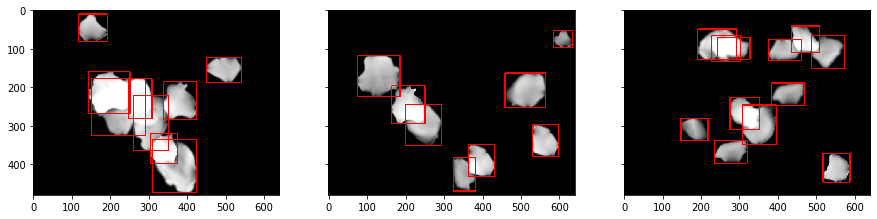

In [24]:
save_path_image=os.path.join('./processed','image','')
save_path_label=os.path.join('./processed','label','')

image_list=[]
for idx in range(3):
    img_test=cv2.imread(os.path.join(save_path_image,'',str(idx)+'.jpg'))
    df=pd.read_csv(os.path.join(save_path_label,'',str(idx)+'.csv'),header=None)
    x_min=df[1]
    y_min=df[2]
    x_max=df[3]
    y_max=df[4]
    
    for count in range(len(x_min)):
        img_test=cv2.rectangle(img_test,(x_min[count],y_min[count]),(x_max[count],y_max[count]),(255,0,0),2)
    image_list.append(img_test)
    


#plt.imshow(img_test)
#print(df)
plot_image(image_list)
